# LOAD PACKAGES

In [1]:
# Load packages
import numpy as np  
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import re
import seaborn as sns
sns.set_style('whitegrid')

from sklearn import cross_validation
from sklearn.preprocessing import StandardScaler
from sklearn.grid_search import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
print "Read in packages from numpy, pandas, sklearn, seaborn & matplotlib"

Read in packages from numpy, pandas, sklearn, seaborn & matplotlib


# LOAD ORIGINAL TRAINING DATA - ORDER, WEATHER

In [3]:
# Load training data
dates_ = range(1, 22)
dates = ["{:02d}".format(item) for item in dates_] 

# Read in order data
order_train = pd.concat( pd.read_table('../../../../../../data/season_1/training_data/order_data/order_data_2016-01-%s' %i, header=None, names = ['order_id', 'driver_id', 'passenger_id', 'start_district_hash', 'dest_district_hash', 'Price', 'Time' ])
                      for i in dates)

# Convert to datetime
order_train['Time'] = pd.to_datetime(order_train['Time'])  

# Read in weather data                                                                                                                                                            
weather_train = pd.concat( pd.read_table('../../../../../../data/season_1/training_data/weather_data/weather_data_2016-01-%s' %i, header=None, names = ['Time', 'Weather', 'temperature', 'PM2.5' ])
                        for i in dates)                      

# Convert to datetime
weather_train['Time'] = pd.to_datetime(weather_train['Time']) 

In [4]:
# Load cluster map - generate dictionary to map district_hash to district_id
district = pd.read_table('../../../../../../data/season_1/test_set_1/cluster_map/cluster_map', sep=' ', header=None, names=['district_hash'])
district = pd.DataFrame(district.district_hash.str.split('\W+',1).tolist(), columns = ['district_hash', 'district_id'])
district_dict = district.set_index('district_hash')['district_id'].to_dict()

# FEATURE PROCESSING

In [5]:
######### FUNCTION DEFINITIONS ####################################################
# Map district_hash to district_id
def dist_hash2id(data_frame, hash_col, district_dict):
    idvalue_array = []
    
    for hash_value in data_frame[hash_col]:
        idvalue_array.append(district_dict[hash_value])
    
    return idvalue_array

# Map time_stamp to time_slot
def time_stamp2slot(arr_hour, arr_minute, arr_second):
    time_slot = []
    
    for hour, minu, sec in zip(arr_hour, arr_minute, arr_second):
        time_slot.append(int((6*hour + 0.1*minu + sec/600) + 1))
    
    return time_slot

# Combine num_day and time_slot to create time_axis
def time_axis(num_day, time_slot):
    return (((num_day - 1)*144) + time_slot)


# Calculate demand, supply and gap per time axis slot
# Demand = Number of orders received (ride requests)
# Supply = Number of orders answered
# Gap = Number of orders missed (NA)
def demand_supply(order_frame):
    
    demand = {}
    supply = {}
    gap = {}
    
    # Initialize demand & supply to zero
    for district in range(1,67):
        for time in range(1,31*144):
            demand[(district, time)] = 0;
            supply[(district, time)] = 0;

    # Iterate over all orders to accumulate demand, supply count for each time slot
    for district_id, num_day, time_slot, answered in zip(order_frame['district_id'], order_frame['num_day'], 
                                                         order_frame['time_slot'], order_frame['driver_id']):
        demand[(int(district_id),time_axis(num_day, time_slot))] += 1;
        supply[(int(district_id),time_axis(num_day, time_slot))] += pd.notnull(answered);
        
    # Calculate the demand-supply gap
    for district in range(1,67):
        for time in range(1,31*144):
            gap[(district, time)] = demand[(district, time)] - supply[(district, time)];
    
    # Use time_slot=1 values to prefill three earlier slots
    # These three earlier time slots are needed to ensure that all input features are defined for time_slot=1
    for district in range(1,67):
        for time in [-2, -1, 0]:
            demand[(district, time)] = demand[(district, 1)]
            supply[(district, time)] = supply[(district, 1)]
            gap[(district, time)] = gap[(district, 1)]
    
    return (demand, supply, gap)

# ORDER, WEATHER FEATURE PROCESSING

In [6]:
####################      ORIGINAL  TRAINING DATA       #############################
# Update ORDER
# IGNORING: order_id, driver_id, passenger_id, price, end_district_hash

# Create following features - time_slot (1...144), week_day (1...7), num_day(1...31) 
order_train.set_index('Time', inplace=True)

order_train['num_day'] = order_train.index.day
order_train['time_slot'] = time_stamp2slot(order_train.index.hour, order_train.index.minute, order_train.index.second)

order_train.reset_index(inplace='True')

order_train['week_day'] = order_train['Time'].dt.dayofweek

# Map start_district_hash (1...66)
order_train['district_id'] = dist_hash2id(order_train, 'start_district_hash', district_dict)

# Calculate demand, supply & gap for all district_id & time_slot
d_train = {}
s_train = {}
g_train = {}
d_train, s_train, g_train = demand_supply(order_train)

###################################################################################
# Update WEATHER

# Create following features - time_slot (1...144), week_day (1...7), num_day(1...31) 
weather_train.set_index('Time', inplace=True)

weather_train['num_day'] = weather_train.index.day
weather_train['time_slot'] = time_stamp2slot(weather_train.index.hour, weather_train.index.minute, weather_train.index.second)

weather_train.reset_index(inplace='True')

weather_train['week_day'] = weather_train['Time'].dt.dayofweek

# TRAFFIC FEATURE PROCESSING

In [7]:
# Generate a traffic index - 1 to 4
# This is a weighted index of all the roads in a district
def get_trafficintensity(tj_level_array):
    
    intensity_array=[]
    
    for tj_level in tj_level_array:
        z=[]
        for t in tj_level.split('\t'):
            z.append(t.split(':'))
            
        weighted_traffic  = 0
        num_roads = 0
            
        for i in range(0,4):
            weighted_traffic +=  (i+1)*int(z[i][1])
            num_roads        +=  int(z[i][1])
    
        intensity = float(weighted_traffic)/num_roads
        intensity_array.append(intensity)
        
    return intensity_array

###################################################################################
# Read in traffic data
traffic_train = []
traffic_train = pd.concat( pd.read_table('../../../../../../data/season_1/training_data/traffic_data/traffic_data_2016-01-%s' %i, sep=' ', header=None, names = ['district_hash_orig', 'time'])
                        for i in dates)
split1 = []
split1 = traffic_train.district_hash_orig.str.split('[\W+]',1).tolist()

district_hash = []
tj_date       = []

for x in split1:
    district_hash.append(x[0])
    tj_date.append(x[1])
    
traffic_train['district_hash'] = district_hash
traffic_train['tj_date']       = tj_date

split2 = traffic_train.tj_date.str.split('(\d{4}\-\d{2}\-\d{2}$)',1).tolist()

tj_level = []
date  = []

for x in split2:
    tj_level.append(x[0])
    date.append(x[1])
    
traffic_train['tj_level'] = tj_level
traffic_train['date']     = date

traffic_train['Time'] = traffic_train.apply(lambda r: str(r.date) + ' ' + str(r.time), axis=1)

# Convert to datetime datatype
traffic_train['Time'] = pd.to_datetime(traffic_train['Time'])

# Update TRAFFIC

# Create following features - time_slot (1...144), week_day (1...7), num_day(1...31) 
traffic_train.set_index('Time', inplace=True)

traffic_train['num_day'] = traffic_train.index.day
traffic_train['time_slot'] = time_stamp2slot(traffic_train.index.hour, traffic_train.index.minute, traffic_train.index.second)

traffic_train.reset_index(inplace='True')

traffic_train['week_day'] = traffic_train['Time'].dt.dayofweek

# Map district_hash (1...66) to district_id
traffic_train['district_id'] = dist_hash2id(traffic_train, 'district_hash', district_dict)

# Create a traffic intensity metric
traffic_train['congestion'] = get_trafficintensity(traffic_train['tj_level'])

traffic_train.drop(['district_hash_orig', 'time', 'tj_date'], axis=1, inplace=True)

In [8]:
traffic_train.shape

(193553, 9)

In [9]:
# Set traffic congestion level for num_day = 2, time = 1 for all 66 districts
for district in range (1,67):
    traffic_data = traffic_train[(traffic_train.num_day == 2) & (traffic_train.time_slot == 1) & 
                                         (traffic_train.district_id == str(district))]
    if traffic_data[['congestion']].empty:
        traffic_data_sub = traffic_data
        time_slot = 144
        
        while (traffic_data_sub[['congestion']].empty & (time_slot > 0)):
            # Find the previous time slot that has traffic information
            traffic_data_sub = traffic_train[(traffic_train.num_day == 1) & (traffic_train.time_slot == time_slot) & 
                                         (traffic_train.district_id == str(district))]
            time_slot -= 1

        if (time_slot == 0):
            sub_congestion = 1.3 # Use mean value - only impacts one district
        else:    
            sub_congestion = traffic_data_sub[['congestion']].values[0][0]
        
        data = {'Time':          pd.to_datetime('2016-01-02 00:00:10'), 
                'district_hash': np.NaN, 
                'tj_level':      np.NaN,
                'date':          '2016-01-02',
                'num_day':       2,
                'time_slot':     1,
                'week_day':      5,
                'district_id':   str(district),
                'congestion':    sub_congestion
               }
        
        df = pd.DataFrame(data, columns=list(traffic_train.columns.values), index=[0])
        traffic_train = traffic_train.append(df)

In [10]:
traffic_train.shape

(193619, 9)

# POI FEATURE PROCESSING

In [11]:
# Read in poi data
poi_train = pd.read_table('../../../../../../data/season_1/training_data/poi_data/poi_data', sep=' ', header=None, names = ['district_hash'])
poi_train = pd.DataFrame(poi_train.district_hash.str.split('\W+',1).tolist(), columns = ['district_hash','poi_class'])

# Map district_hash (1...66) to district_id
poi_train['district_id'] = dist_hash2id(poi_train, 'district_hash', district_dict)

# Parse & extract the poi labels
def poi_all(poi_list):
    z=[]
    for t in poi_list.split('\t'):
        z.append(t.split(':'))
        
    # sort in-place from highest to lowest
    z.sort(key=lambda x: int(x[1]), reverse=True)
    return z

# Update poi_train with all unique poi labels
rr =[]
rr = poi_train.apply(lambda r: poi_all(r.poi_class), axis=1)

t =[]
for x in rr.values:
    for i in range(0,len(x)):
        t.append(x[i][0])
uniquepoi_set  = set(t)
uniquepoi_list = list(uniquepoi_set)

# Add one column for each unique poi label initialize to 0
poi_train = pd.concat([poi_train,pd.DataFrame(columns=uniquepoi_list)])
poi_train = poi_train.fillna(0)

# Fill in poi values for all districts
for i in range(0,66):
    for j in range(0,len(rr[i])):
        # (row, col, value)
        poi_train.set_value(i, rr[i][j][0], rr[i][j][1])

Transformed training set
PCA Components: 
[[-0.0959727  -0.08365848 -0.0551605  ..., -0.09594505 -0.01622104
  -0.00651075]
 [-0.00795904  0.01080011 -0.07342155 ...,  0.03541007  0.03300975
  -0.02028575]
 [ 0.02770358  0.04447274  0.1612399  ..., -0.01502188 -0.03874987
   0.02605915]
 ..., 
 [ 0.01943474  0.02771459 -0.01132678 ...,  0.02073466 -0.02922079
  -0.34033047]
 [ 0.02140603 -0.00881405 -0.05787585 ...,  0.0311171   0.03582543
  -0.06019781]
 [-0.0281531   0.03662713  0.07941624 ..., -0.02160907  0.02285806
  -0.0386367 ]]
PCA Explained Variance Ratio: 
[ 0.59316654  0.06522435  0.03398176  0.02982427  0.02261498  0.02060699
  0.01932321  0.01778027  0.01683588  0.01430757]


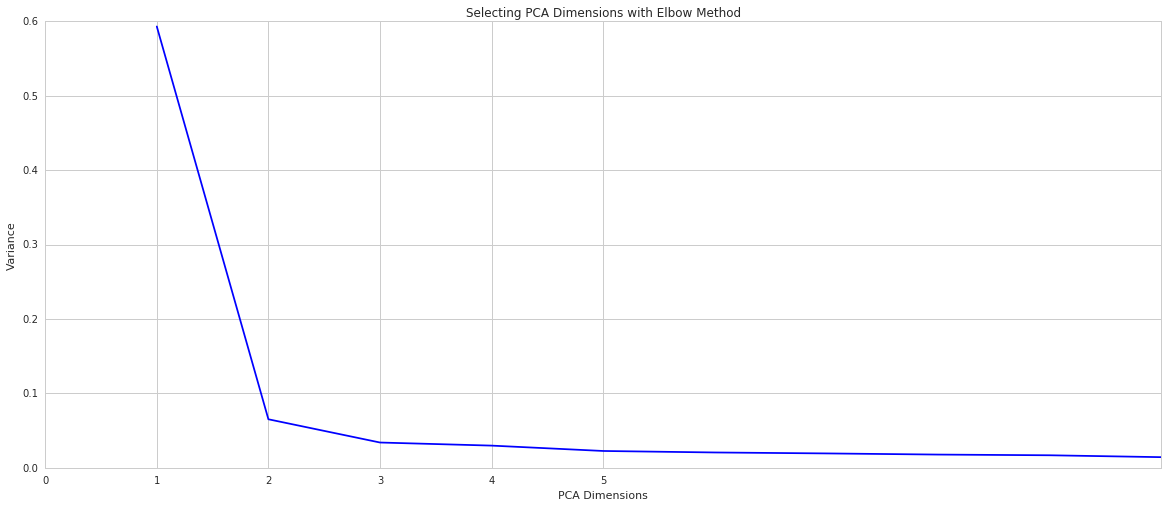

In [12]:
# Perform Principal Component Analysis (PCA)
poi_train_pca = poi_train.drop(['district_hash', 'poi_class'], axis=1)
poi_train_pca.set_index('district_id', inplace=True)

# Normalize each column
scaler = StandardScaler().fit(poi_train_pca)
poi_train_pca_trans = scaler.transform(poi_train_pca)
print ("Transformed training set")

from sklearn.decomposition import PCA
pca = PCA(n_components=10)
pca.fit(poi_train_pca_trans)

# Print the components and the amount of variance in the data contained in each dimension
print "PCA Components: \n{}" .format(pca.components_)
print "PCA Explained Variance Ratio: \n{}" .format(pca.explained_variance_ratio_)

# Plot Variance by number of components
x = np.array(range(1,11))
f, ax = plt.subplots(figsize=(20, 8))
plt.plot(x, pca.explained_variance_ratio_, 'bx-') 
plt.xlabel('PCA Dimensions') 
plt.ylabel('Variance') 
plt.title('Selecting PCA Dimensions with Elbow Method')
ax.set_xticks(np.arange(0,6))
plt.show()

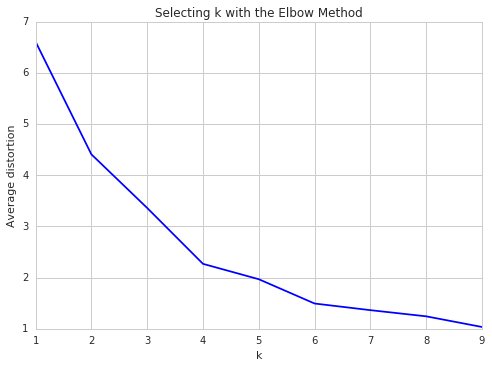

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=6, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=None, tol=0.0001,
    verbose=0)


In [13]:
# Import clustering modules
from sklearn.cluster import KMeans
from sklearn.mixture import GMM

# Reduce the data to two dimensions using PCA to capture variation
pca2 = PCA(n_components=2)
reduced_data = pca2.fit_transform(poi_train_pca_trans)
#print reduced_data[:10]  # print upto 10 elements

# Implement clustering algorithm and fit it to the reduced data for visualization
# The visualizer below assumes clustering object is named 'clusters'

# Implement elbow method to determine n_clusters
from scipy.spatial.distance import cdist

K = range(1, 10) 
meandistortions = [] 
for k in K: 
     kmeans = KMeans(n_clusters=k) 
     kmeans.fit(reduced_data) 
     meandistortions.append(sum(np.min(cdist(reduced_data, kmeans.cluster_centers_, 'euclidean'), axis=1)) / reduced_data.shape[0]) 

plt.plot(K, meandistortions, 'bx-') 
plt.xlabel('k') 
plt.ylabel('Average distortion') 
plt.title('Selecting k with the Elbow Method') 
plt.show()

# Derived n_clusters=6 from Elbow Plot 
clusters = KMeans(n_clusters=6)
clusters.fit(reduced_data)
print clusters

In [14]:
# Plot the decision boundary by building a mesh grid to populate a graph.
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
hx = (x_max-x_min)/1000.
hy = (y_max-y_min)/1000.
xx, yy = np.meshgrid(np.arange(x_min, x_max, hx), np.arange(y_min, y_max, hy))

# Obtain labels for each point in mesh. Use last trained model.
Z = clusters.predict(np.c_[xx.ravel(), yy.ravel()])

# Create new column that stores cluster labels
poi_train['poi_cluster'] = clusters.labels_

# Find the centroids for KMeans or the cluster means for GMM 
centroids = clusters.cluster_centers_
centroids_inv = pca2.inverse_transform(centroids)
print "Centroids transformed back to original space:"
print np.around(centroids_inv, 0)

print "Scaled Centroids in original space:"
scaled_centroids_inv = np.apply_along_axis(lambda x: x/np.linalg.norm(x), 1, centroids_inv) 
print np.around(scaled_centroids_inv, 5)

# Bar plot
#pd.DataFrame(scaled_centroids_inv, columns = poi_train_pca.columns, index = ["Cluster {}".format(i) for i in range(1, 7)]).plot(kind = 'bar')

Centroids transformed back to original space:
[[ 1.  0.  1. ...,  0. -0.  0.]
 [ 6.  5.  2. ...,  6.  1.  0.]
 [-0. -0. -0. ..., -0. -0. -0.]
 [ 3.  2.  2. ...,  2.  0.  0.]
 [ 2.  1.  1. ...,  2.  0.  0.]
 [-0. -0. -0. ..., -0. -0.  0.]]
Scaled Centroids in original space:
[[ 0.08607  0.06579  0.08533 ...,  0.06346 -0.00335  0.01612]
 [ 0.0909   0.08369  0.03496 ...,  0.10176  0.02399  0.00121]
 [-0.09552 -0.07956 -0.06928 ..., -0.08643 -0.00897 -0.01061]
 [ 0.0919   0.07343  0.07875 ...,  0.07555  0.0026   0.01367]
 [ 0.09602  0.08358  0.05565 ...,  0.09571  0.016    0.00665]
 [-0.08623 -0.08172 -0.02411 ..., -0.10224 -0.02727  0.00145]]


In [40]:
# Find the representative districts for each of the six clusters
for c_index, c in enumerate(centroids):
    shortest_dist = float('inf')
    closest_idx = -1
    for d_index, d in enumerate(reduced_data):
        dist = np.linalg.norm(c-d)
        if (dist < shortest_dist):
            shortest_dist = dist
            closest_idx = d_index
            
    print 'District #{0:2d} is the closest to centroid in cluster {1:2d}' .format(int(poi_train.iloc[[closest_idx]]['district_id']), 
                                                                       c_index+1)
        

District #46 is the closest to centroid in cluster  1
District #51 is the closest to centroid in cluster  2
District #39 is the closest to centroid in cluster  3
District #23 is the closest to centroid in cluster  4
District #12 is the closest to centroid in cluster  5
District #19 is the closest to centroid in cluster  6


In [27]:
print centroids

[[ -5.16439089  -3.15120002]
 [-59.48457131  15.43164989]
 [  4.80553829   1.02666577]
 [-26.48580892 -10.76703803]
 [-15.80056117  -0.10538477]
 [  1.32589605  -0.52750847]]


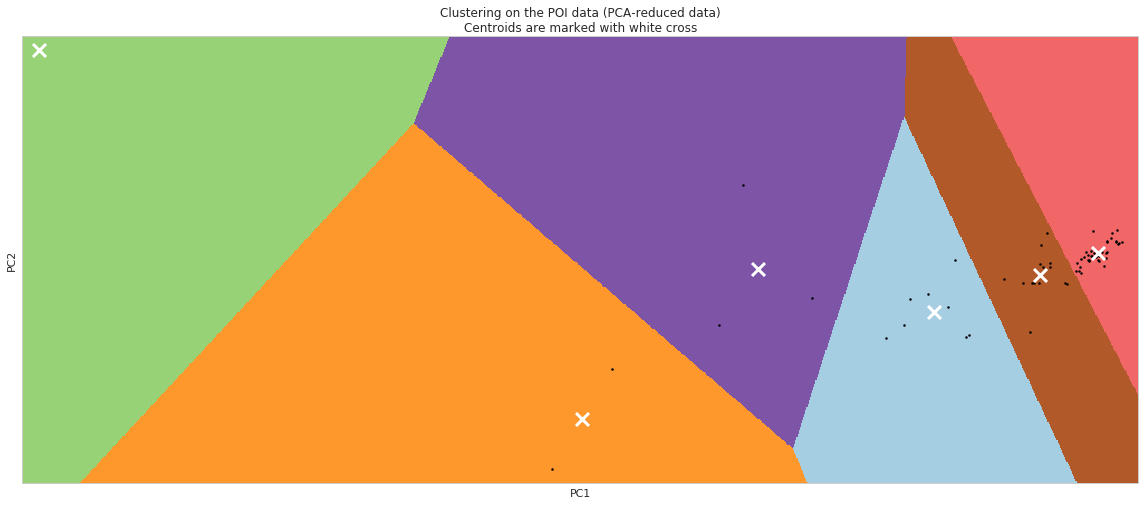

                  1          1#1        1#10         1#11          1#2  \
count     66.000000    66.000000   66.000000    66.000000    66.000000   
mean     993.484848   111.924242   77.969697   965.818182   601.121212   
std     1851.761276   192.870408  141.814610  1263.600861  1038.106168   
min        0.000000     0.000000    0.000000     0.000000     0.000000   
25%       83.000000     0.000000    0.000000   103.750000    83.000000   
50%      332.000000     0.000000    0.000000   498.000000   166.000000   
75%      892.250000   166.000000   83.000000  1224.250000   643.250000   
max    10790.000000  1079.000000  830.000000  5644.000000  6557.000000   

               1#3          1#4           1#5         1#6         1#7  \
count    66.000000    66.000000     66.000000   66.000000   66.000000   
mean    196.181818   114.439394   3946.272727   94.318182   54.075758   
std     463.072113   215.831995   6746.474609  121.711786  120.491852   
min       0.000000     0.000000      0.00

In [15]:
# Scatter Plot for Cluster Visualization
Z = Z.reshape(xx.shape)

plt.figure(figsize=(20,8))
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=5)
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)
plt.title('Clustering on the POI data (PCA-reduced data)\n'
          'Centroids are marked with white cross')
plt.xlabel('PC1') 
plt.ylabel('PC2')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

print poi_train.describe()
print poi_train.head()

In [16]:
def get_poicluster(district):
    return int(poi_train[(poi_train.district_id==str(district))]['poi_cluster'])

# GENERATE UNIFIED DATAFRAME

In [17]:
# Create train_set
train_set    = pd.DataFrame()
prev_traffic = {}

for district in range(1,67):
    for day in range(2,23):
        for time in range(1,145):
            
            weather_data = weather_train[(weather_train.num_day == day) & (weather_train.time_slot == time)]
            
            # check if weather data is missing
            # use previous data if current time slot data is empty
            if weather_data[['Weather']].empty:
                curr_weather = prev_weather
                curr_temperature = prev_temperature
                curr_pollution = prev_pollution
            else:
                curr_weather = int(weather_data[['Weather']].max())
                prev_weather = curr_weather
                curr_temperature = int(weather_data[['temperature']].max())
                prev_temperature = curr_temperature
                curr_pollution = int(weather_data[['PM2.5']].max())
                prev_pollution = curr_pollution
                
            
            
            traffic_data = traffic_train[(traffic_train.num_day == day) & (traffic_train.time_slot == time) & 
                                         (traffic_train.district_id == str(district))]
            
            # check if traffic data is missing
            # use previous data if current time slot data is empty
            if traffic_data[['congestion']].empty:
                curr_traffic = prev_traffic[str(district)]
            else:
                curr_traffic = traffic_data['congestion']
                prev_traffic[str(district)] = curr_traffic
            
            data = {'district_id': [district], 'num_day': [day], 'time_slot': [time],
                    'week_day': [(day+3)%7],
                    'demand': d_train[(district,time_axis(day,time))],
                    'demand_t-1': d_train[(district,time_axis(day,time-1))],
                    'demand_t-2': d_train[(district,time_axis(day,time-2))],
                    'demand_t-3': d_train[(district,time_axis(day,time-3))],
                    'supply': s_train[(district,time_axis(day,time))],
                    'supply_t-1': s_train[(district,time_axis(day,time-1))],
                    'supply_t-2': s_train[(district,time_axis(day,time-2))],
                    'supply_t-3': s_train[(district,time_axis(day,time-3))],
                    'gap': g_train[(district,time_axis(day,time))],
                    'weather': curr_weather,
                    'temperature': curr_temperature,
                    'pollution': curr_pollution,
                    'poi_cluster': get_poicluster(district),
                    'congestion' : curr_traffic
                   }
            df = pd.DataFrame(data, columns=['district_id', 'num_day', 'time_slot', 'week_day', 'demand',
                                             'demand_t-1', 'demand_t-2', 'demand_t-3', 'supply', 'supply_t-1',
                                             'supply_t-2', 'supply_t-3','gap', 'weather', 'temperature', 
                                             'pollution', 'poi_cluster', 'congestion'])
            train_set = train_set.append(df)

In [18]:
print "Shape of train set:", train_set.shape, "\n\n"
print "Column Headers:", list(train_set.columns.values), "\n\n"
print train_set.dtypes, "\n\n"
print train_set.head(5), "\n\n"
print train_set.describe(), "\n\n"

Shape of train set: (199584, 18) 


Column Headers: ['district_id', 'num_day', 'time_slot', 'week_day', 'demand', 'demand_t-1', 'demand_t-2', 'demand_t-3', 'supply', 'supply_t-1', 'supply_t-2', 'supply_t-3', 'gap', 'weather', 'temperature', 'pollution', 'poi_cluster', 'congestion'] 


district_id      int64
num_day          int64
time_slot        int64
week_day         int64
demand           int64
demand_t-1       int64
demand_t-2       int64
demand_t-3       int64
supply           int64
supply_t-1       int64
supply_t-2       int64
supply_t-3       int64
gap              int64
weather          int64
temperature      int64
pollution        int64
poi_cluster      int64
congestion     float64
dtype: object 


       district_id  num_day  time_slot  week_day  demand  demand_t-1  \
0                1        2          1         5      88          84   
15903            1        2          2         5      97          88   
16089            1        2          3         5      75          9

In [95]:
# Create a dataframe with data from representative districts
rep_dists = [12,19,23,39,46,51]
plot_set = train_set[(train_set['district_id'].isin(rep_dists))]

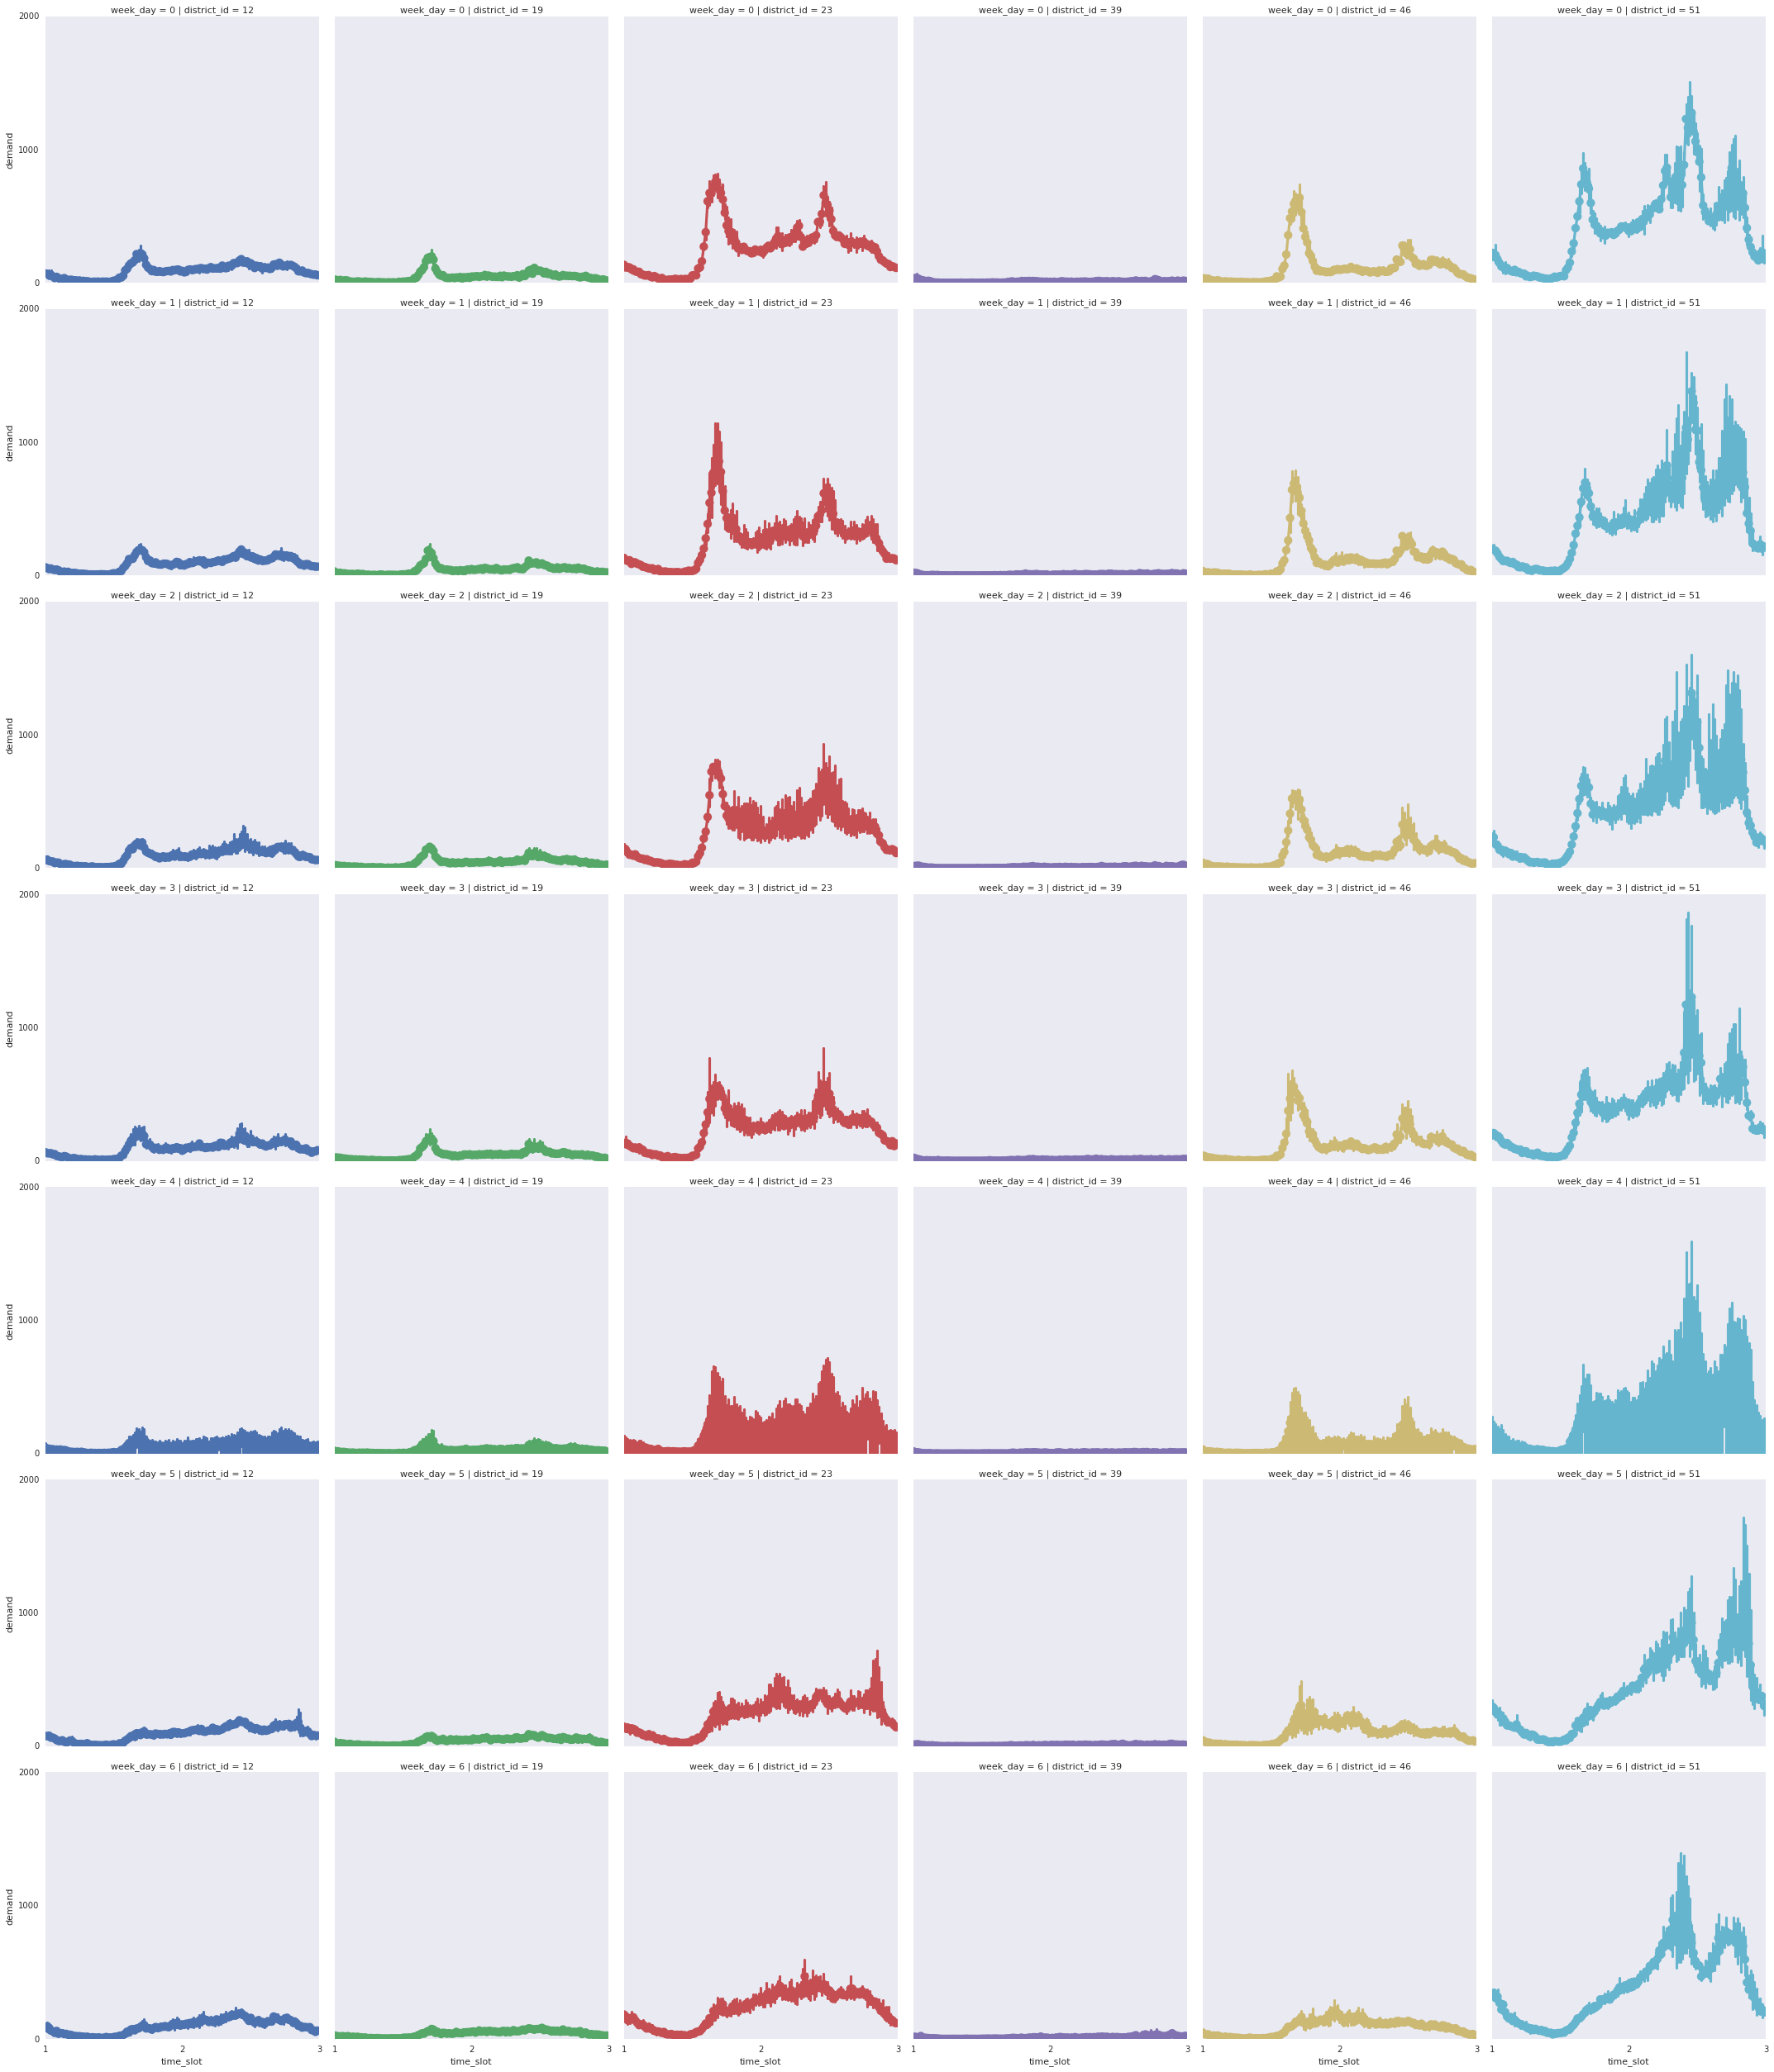

In [96]:
# Generate grid of demand plots for representative districts by week day
sns.set(style='dark')

print 'Demand Plots'

# Initialize a grid of plots
# Column indicates district_id, row indicates week_day
grid = sns.FacetGrid(plot_set, col='district_id', hue='district_id', row='week_day', size=5)

# Draw the time graph
grid.map(sns.pointplot, 'time_slot', 'demand')

# Adjust the tick positions and labels
grid.set(xlim=(0, 144), ylim=(0, 2000), xticks=[0, 72, 144], yticks=[0, 1000, 2000])

# Adjust the arrangement of the plots
grid.fig.tight_layout(w_pad=1)

Supply Plots


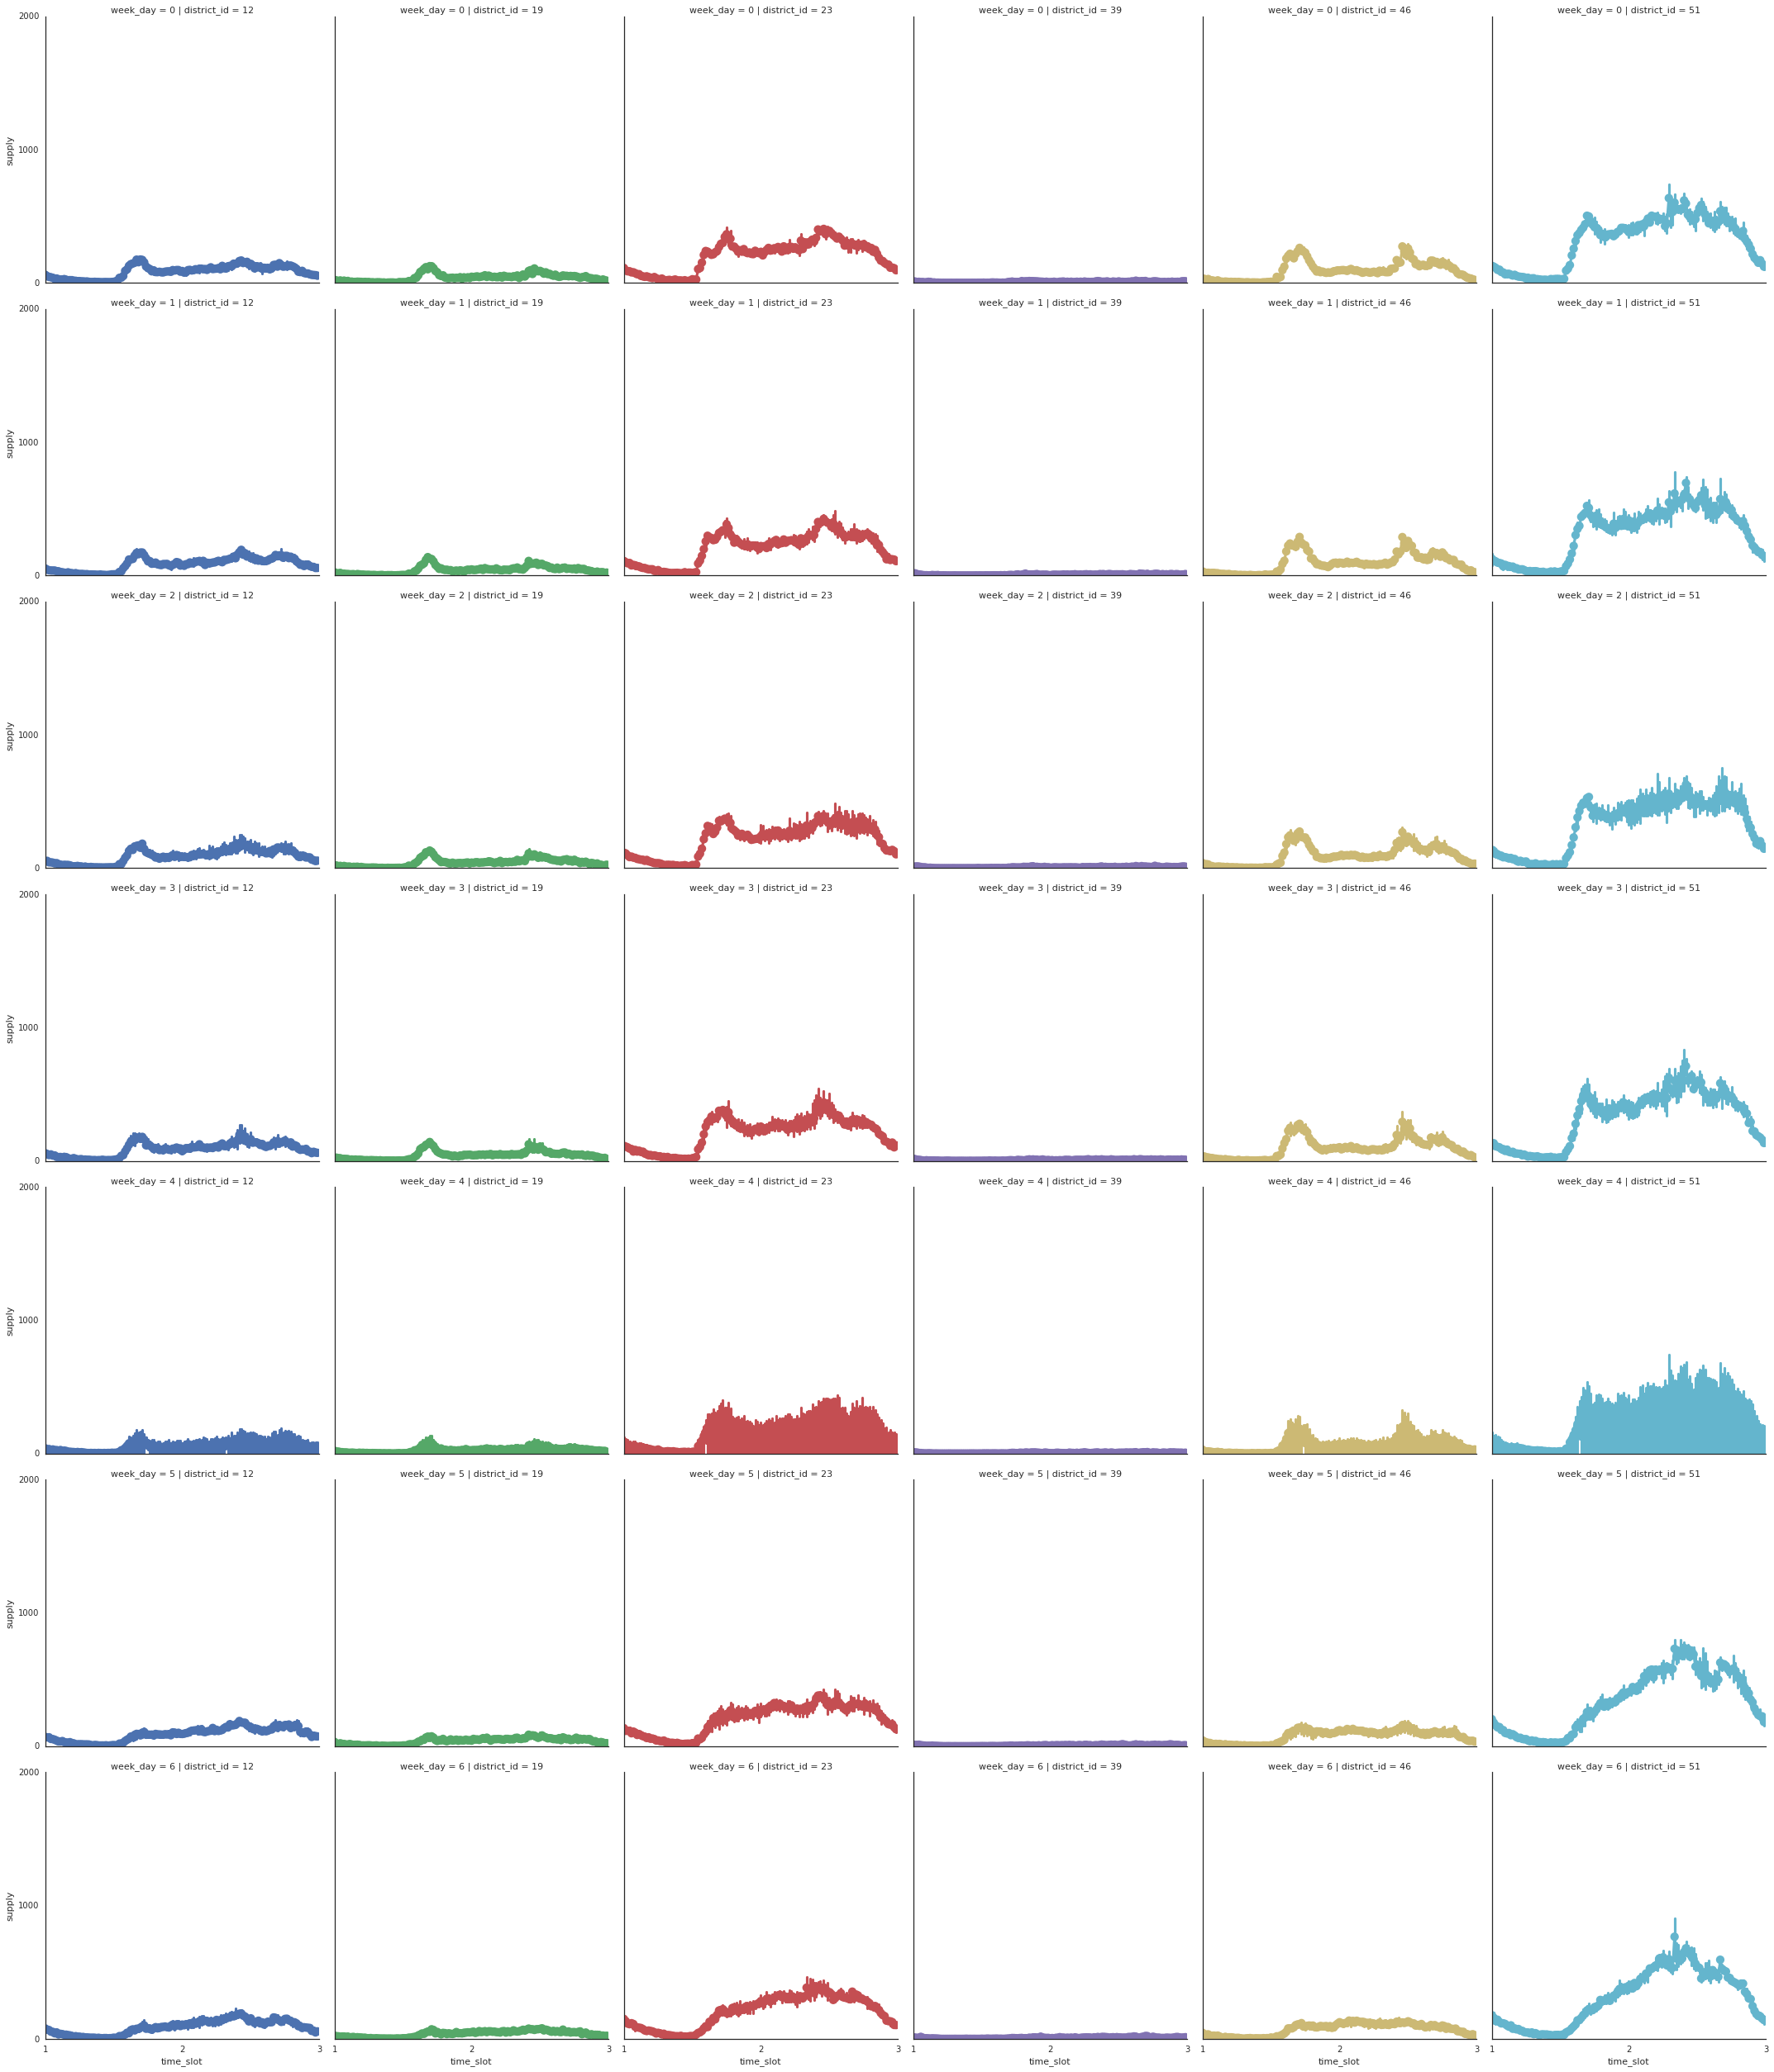

In [97]:
# Generate grid of supply plots for representative districts by week day
sns.set(style='white')

print 'Supply Plots'

# Initialize a grid of plots
# Column indicates district_id, row indicates week_day
grid = sns.FacetGrid(plot_set, col='district_id', hue='district_id', row='week_day', size=5)

# Draw the time graph
grid.map(sns.pointplot, 'time_slot', 'supply')

# Adjust the tick positions and labels
grid.set(xlim=(0, 144), ylim=(0, 2000), xticks=[0, 72, 144], yticks=[0, 1000, 2000])

# Adjust the arrangement of the plots
grid.fig.tight_layout(w_pad=1)

Deman Supply Gap Plots


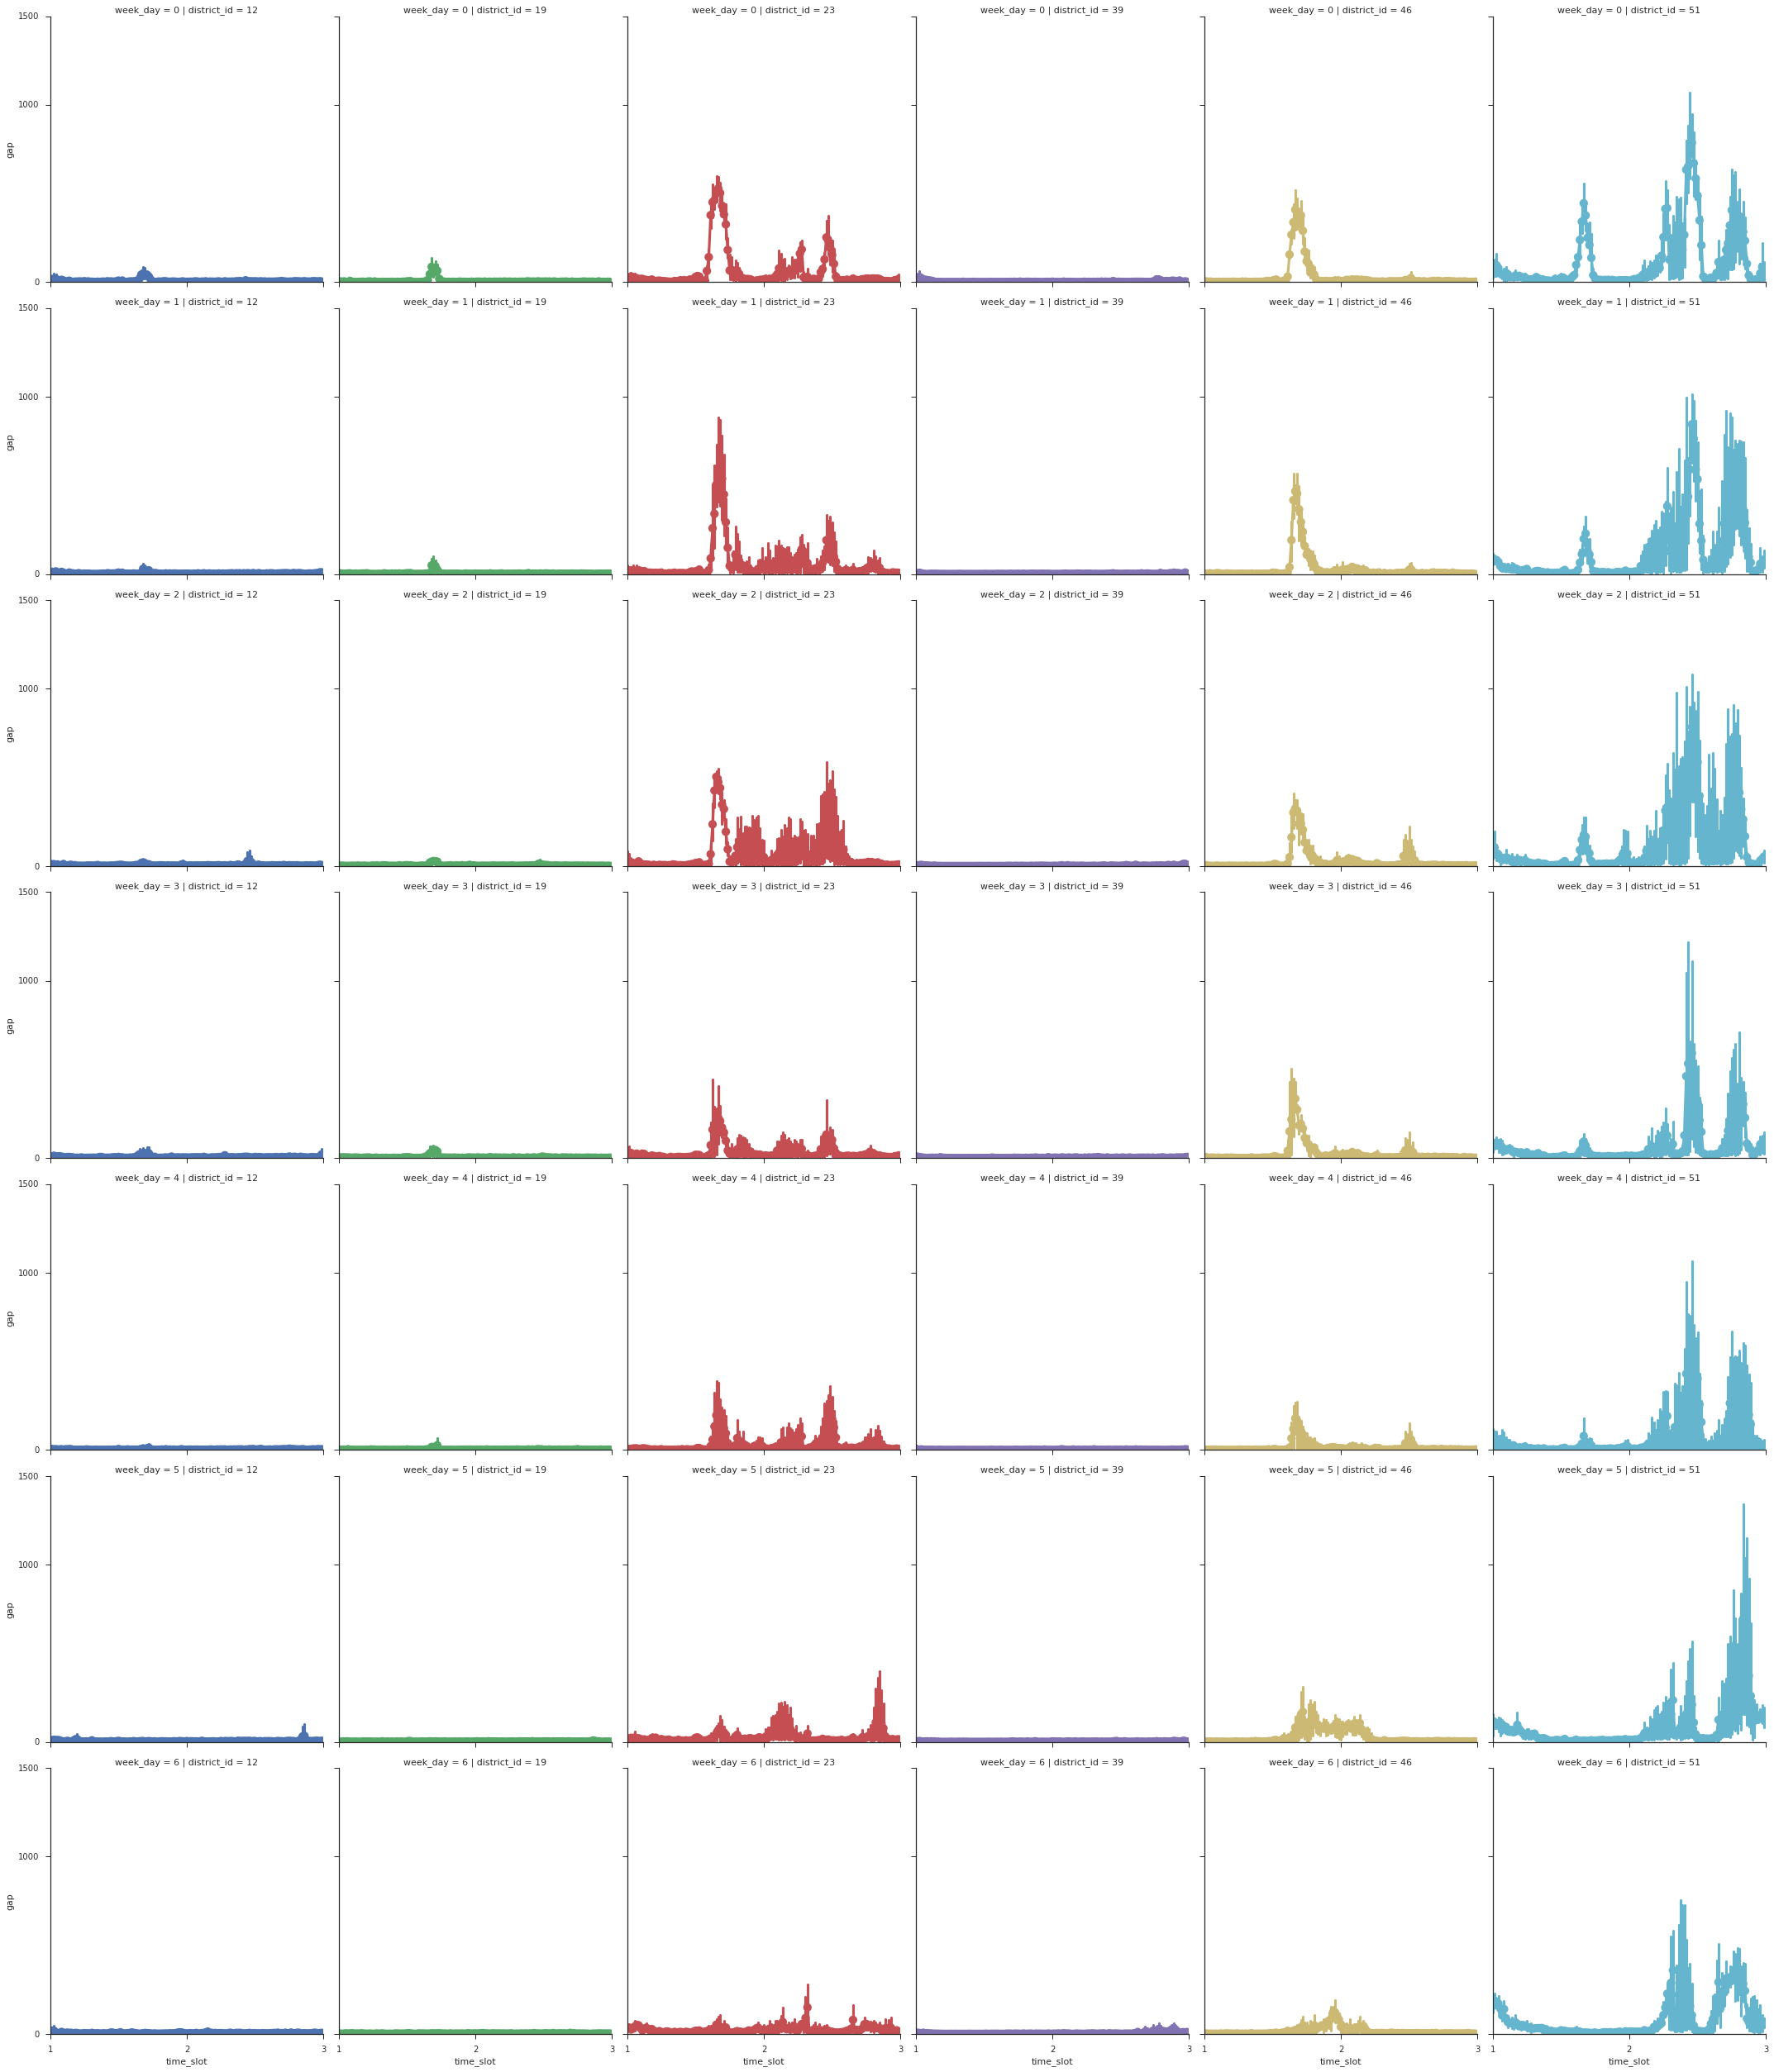

In [100]:
# Generate grid of demand supply gap plots for representative districts by week day
sns.set(style='ticks')

print 'Demand Supply Gap Plots'

# Initialize a grid of plots
# Column indicates district_id, row indicates week_day
grid = sns.FacetGrid(plot_set, col='district_id', hue='district_id', row='week_day', size=5)

# Draw the time graph
grid.map(sns.pointplot, 'time_slot', 'gap')

# Adjust the tick positions and labels
grid.set(xlim=(0, 144), ylim=(0, 1500), xticks=[0, 72, 144], yticks=[0, 1000, 1500])

# Adjust the arrangement of the plots
grid.fig.tight_layout(w_pad=1)

# TRAIN / VALIDATE / TEST SPLIT

In [23]:
# Split train / test data - for coarse training
train_days     = range(2,16)
train_times    = range(39,140,4)
validate_days  = [16, 18, 20]
validate_times = range(39,140,4)
test_days      = [17, 19, 21]
test_times     = range(40,141,4)

X_train     = train_set[(train_set['num_day'].isin(train_days)) & (train_set['time_slot'].isin(train_times))]
X_validate  = train_set[(train_set['num_day'].isin(validate_days)) & (train_set['time_slot'].isin(validate_times))]
X_test      = train_set[(train_set['num_day'].isin(test_days)) & (train_set['time_slot'].isin(test_times))]

print "Shape of X_train, X_validate, X_test:", X_train.shape, X_validate.shape, X_test.shape, "\n\n"

print "X_train\n"
print X_train.head(5), "\n\n"
print X_train.describe(), "\n\n"

print "X_validate\n"
print X_validate.head(5), "\n\n"
print X_validate.describe(), "\n\n"

print "X_test\n"
print X_test.head(5), "\n\n"
print X_test.describe(), "\n\n"

Shape of X_train, X_validate, X_test: (24024, 18) (5148, 18) (5148, 18) 


X_train

       district_id  num_day  time_slot  week_day  demand  demand_t-1  \
11105            1        2         39         5      14          27   
15718            1        2         43         5      55          28   
16478            1        2         47         5     100          66   
11843            1        2         51         5     115         121   
12568            1        2         55         5     106         106   

       demand_t-2  demand_t-3  supply  supply_t-1  supply_t-2  supply_t-3  \
11105          18          12      12          20          17           6   
15718          36          22      53          28          35          22   
16478          52          60      96          66          52          59   
11843          91          78     114         117          91          78   
12568         137         112     102         101         134         110   

       gap  weather 

# SCORES

In [19]:
# Calculate the MAPE Score
def mape_score(exp, pred):
    mape = 0.0
    n = 66.0
    q = 43.0
    for gap, gapX in zip(exp, pred):
        if gap > 0:
            mape += 1.0 * abs((gap-gapX)/gap)
    return (mape/(n*q))

# Evaluate Scores & Present as a table - Mean Squared, R2, MAPE
def eval_score(y_train, y_pred_train, y_validate, y_pred_validate, y_test, y_pred_test):
    
    m2score_train    = metrics.mean_squared_error(y_train,    y_pred_train)
    m2score_validate = metrics.mean_squared_error(y_validate, y_pred_validate)
    m2score_test     = metrics.mean_squared_error(y_test,     y_pred_test)


    r2score_train    = metrics.r2_score(y_train,    y_pred_train)
    r2score_validate = metrics.r2_score(y_validate, y_pred_validate)
    r2score_test     = metrics.r2_score(y_test,     y_pred_test)

    mpscore_train    = mape_score(y_train,    y_pred_train)
    mpscore_validate = mape_score(y_validate, y_pred_validate)
    mpscore_test     = mape_score(y_test,     y_pred_test)


    sets_list = ["TRAIN", "VALIDATE", "TEST"]

    m2_scores = [m2score_train, m2score_validate, m2score_test]
    r2_scores = [r2score_train, r2score_validate, r2score_test]
    mp_scores = [mpscore_train, mpscore_validate, mpscore_test]


    print '\t\tMEAN^2\t\tR2\t\tMAPE'


    for s, m, r, mp in zip(sets_list, m2_scores, r2_scores, mp_scores):
        print '{0:10}\t{1:.2f}\t\t{2:.2f}\t\t{3:.2f}' .format(s, m, r, mp)

# DEMAND, SUPPLY PREDICTIONS & GAP FORECASTING

In [20]:
# Use fit function to generate predictions for train, validate and test sets
# Evaluate scores and print results
# Used for demand, supply predictions
def predict_score(train_set, validate_set, test_set, predictors, exp_col, fitfunc, *fitargs):

    # Generate dataframe for train, validate & test
    Xtrain_df    = train_set[predictors]
    Xvalidate_df = validate_set[predictors]
    Xtest_df     = test_set[predictors]
    
    # Generate predictions for train, validate & test
    y_pred_train    = fitfunc(Xtrain_df,    *fitargs)
    y_pred_validate = fitfunc(Xvalidate_df, *fitargs)
    y_pred_test     = fitfunc(Xtest_df,     *fitargs)

    # Extract expected train, validated & test values
    y_train    = train_set[exp_col]
    y_validate = validate_set[exp_col]
    y_test     = test_set[exp_col]

    # Evaluate scores and print results
    eval_score(y_train, y_pred_train, y_validate, y_pred_validate, y_test, y_pred_test)
    
    return(y_pred_train, y_pred_validate, y_pred_test)

In [21]:
# Generate Demand Supply Gap Metrics based on provided fit functions
# Assumes expected values for demand, supply, gap are in namesake columns
def gap_forecast(**kwargs):
    
    X_train      = kwargs["train_set"]
    X_validate   = kwargs["validate_set"]
    X_test       = kwargs["test_set"]
    r_predictors = kwargs["demand_predictors"]
    a_predictors = kwargs["supply_predictors"]
    r_fitfunc    = kwargs["rfit_func"]
    r_fitargs    = kwargs["rfit_args"]
    a_fitfunc    = kwargs["afit_func"]
    a_fitargs    = kwargs["afit_args"]
    
    print "\n\nDEMAND FORECASTING"
    print     "=================="

    ry_pred_train, ry_pred_validate, ry_pred_test = predict_score(X_train, X_validate, X_test, 
                                                                  r_predictors, 'demand', 
                                                                  r_fitfunc, *r_fitargs)

    print "\n\nSUPPLY FORECASTING"
    print     "=================="

    ay_pred_train, ay_pred_validate, ay_pred_test = predict_score(X_train, X_validate, X_test,
                                                                  a_predictors, 'supply', 
                                                                  a_fitfunc, *a_fitargs)

    print "\n\nGAP FORECASTING"
    print     "==============="

    gapy_pred_train    = [r - a for r, a in zip(ry_pred_train,    ay_pred_train)]
    gapy_pred_validate = [r - a for r, a in zip(ry_pred_validate, ay_pred_validate)]
    gapy_pred_test     = [r - a for r, a in zip(ry_pred_test,     ay_pred_test)]

    gapy_train    = X_train['gap']
    gapy_validate = X_validate['gap']
    gapy_test     = X_test['gap']

    eval_score(gapy_train, gapy_pred_train, gapy_validate, gapy_pred_validate, gapy_test, gapy_pred_test)
    
    return

# BENCHMARK - SIMPLE AVERAGE

In [24]:
# Return simple average of previous 3 time slots
def simple_average(df, t1, t2, t3):
    return df.apply(lambda r: ((r[t1] + r[t2] + r[t3]) / 3.0), axis=1)

# Define list of predictors for demand, supply
r_predictors = ['district_id', 'num_day', 'time_slot', 'demand_t-1', 'demand_t-2', 'demand_t-3'] 
a_predictors = ['district_id', 'num_day', 'time_slot', 'supply_t-1', 'supply_t-2', 'supply_t-3']

# Set arguments for gap forecasting function
kwargs = {"train_set": X_train, "validate_set": X_validate, "test_set": X_test, 
          "demand_predictors": r_predictors, "supply_predictors": a_predictors,
          "rfit_func": simple_average, "rfit_args": ['demand_t-1','demand_t-2','demand_t-3'],
          "afit_func": simple_average, "afit_args": ['supply_t-1','supply_t-2','supply_t-3']}

gap_forecast(**kwargs)



DEMAND FORECASTING
		MEAN^2		R2		MAPE
TRAIN     	784.82		0.93		3.24
VALIDATE  	1055.78		0.94		0.66
TEST      	888.39		0.94		0.69


SUPPLY FORECASTING
		MEAN^2		R2		MAPE
TRAIN     	252.86		0.96		2.90
VALIDATE  	262.72		0.97		0.60
TEST      	241.56		0.97		0.63


GAP FORECASTING
		MEAN^2		R2		MAPE
TRAIN     	508.04		0.59		4.40
VALIDATE  	776.12		0.77		0.98
TEST      	639.48		0.77		0.89


In [ ]:
x, y = pd.Series(gapy_test, name="Actual"), pd.Series(gapy_pred_test, name="Predicted")

f, ax = plt.subplots(figsize=(8, 8))
f.suptitle('Test Data Regplot', fontsize=20)
sns.regplot(x=x, y=y, ax=ax, color="g")

In [106]:
print [int(x) for x in ry_train[:5]]
print [int(x) for x in ay_train[:5]]


print [int(x) for x in ry_pred_train[:5]]
print [int(x) for x in ay_pred_train[:5]]

print [int(x) for x in gapy_pred_train[:5]]
print [x for x in gapy_train[:5]]

[14, 55, 100, 115, 106]
[12, 53, 96, 114, 102]
[19, 28, 59, 96, 118]
[14, 28, 59, 95, 115]
[4, 0, 0, 1, 3]
[2, 2, 4, 1, 4]


# FEATURE IMPORTANCE

In [123]:
# Assess Feature importance
r_predictors = ['district_id', 'num_day', 'time_slot', 'week_day', 'demand_t-1', 'demand_t-2', 'demand_t-3', 
                'weather', 'temperature', 'pollution'] 

a_predictors = ['district_id', 'num_day', 'time_slot', 'week_day', 'supply_t-1', 'supply_t-2', 'supply_t-3', 
                'weather', 'temperature', 'pollution'] 

# Normalize features - both training & test (withheld & final)
#scaler = StandardScaler().fit(train_set)
#train_set_trans = scaler.transform(train_set)
#print ("Transformed training set")

# Scoring Metric - MSE
print ("Use MSE as the score function")

# Input Samples and Target Values for Demand(r), Supply(a)
r_train  = train_set[r_predictors]
ry_train = train_set['demand']

a_train  = train_set[a_predictors]
ay_train = train_set['supply']

# Fit Random Forest Regressor for Demand & Supply Predictors
alg = RandomForestRegressor(random_state=1, n_estimators=1000, min_samples_split=50, min_samples_leaf=1)
r_clf = alg.fit(r_train, ry_train)
a_clf = alg.fit(a_train, ay_train)

Use MSE as the score function


 1) demand_t-1                     0.989196
 2) time_slot                      0.004408
 3) demand_t-2                     0.002317
 4) demand_t-3                     0.002096
 5) district_id                    0.000739
 6) pollution                      0.000505
 7) num_day                        0.000269
 8) temperature                    0.000202
 9) week_day                       0.000197
10) weather                        0.000071


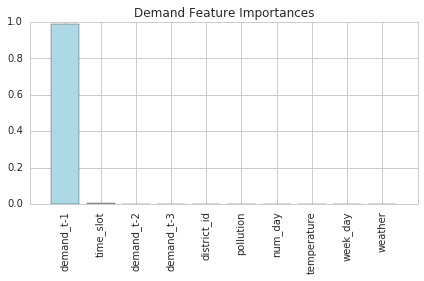

In [124]:
# Feature importances - Demand (r)
importances = r_clf.feature_importances_
indices = np.argsort(importances)[::-1]
feature_labels = r_predictors
for f in range(r_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, 
                             feature_labels[indices[f]], 
                             importances[indices[f]]))

labels_reordered = [feature_labels[i] for i in indices]
    
plt.title('Demand Feature Importances')
plt.bar(range(r_train.shape[1]), 
         importances[indices],
         color='lightblue', 
         align='center')
plt.xticks(range(r_train.shape[1]), labels_reordered, rotation=90)
plt.xlim([-1, r_train.shape[1]])
plt.tight_layout()
plt.show()

 1) supply_t-1                     0.989196
 2) time_slot                      0.004408
 3) supply_t-2                     0.002317
 4) supply_t-3                     0.002096
 5) district_id                    0.000739
 6) pollution                      0.000505
 7) num_day                        0.000269
 8) temperature                    0.000202
 9) week_day                       0.000197
10) weather                        0.000071


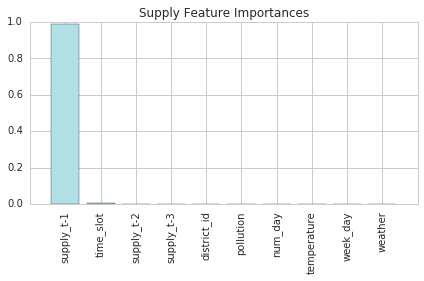

In [125]:
# Feature importances - Supply (a)
importances = a_clf.feature_importances_
indices = np.argsort(importances)[::-1]
feature_labels = a_predictors
for f in range(a_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, 
                             feature_labels[indices[f]], 
                             importances[indices[f]]))

labels_reordered = [feature_labels[i] for i in indices]
    
plt.title('Supply Feature Importances')
plt.bar(range(a_train.shape[1]), 
         importances[indices],
         color='powderblue', 
         align='center')
plt.xticks(range(a_train.shape[1]), labels_reordered, rotation=90)
plt.xlim([-1, a_train.shape[1]])
plt.tight_layout()
plt.show()

# PLOTS

In [ ]:
# Plot training data: d, s, g
dplot = []
splot = []
gplot = []

trange   = range(1,21*144)
pltrange = max(trange)-min(trange)

for t in trange:
    dplot.append(d_train[(20,t)])
    splot.append(s_train[(20,t)])
    gplot.append(g_train[(20,t)])

f, (ax1,ax2,ax3) = plt.subplots(3,1, sharex=True, figsize=(20,15))
plt.xlim(0, pltrange)
ax1.grid(True)
#ax1.set_yticks(np.arange(0,160,20))
ax1.set_xticks(np.arange(0, pltrange,144))
    
sns.tsplot(data=dplot, ax=ax1, value="demand")
sns.tsplot(data=splot, ax=ax2, value="supply")
sns.tsplot(data=gplot, ax=ax3, value="gap")

In [ ]:
d_test = {}
s_test = {}
g_test = {}
d_test, s_test, g_test = demand_supply(order_test)

# Plot a distribution plot
dist = range(15,30)
time = range(21*144,31*144)

dplot = []
splot = []
gplot = []
for t in range(21*144,31*144):
    dplot.append(d[(20,t)])
    splot.append(s[(20,t)])
    gplot.append(g[(20,t)])

f, (axis1,axis2,axis3) = plt.subplots(3,1, sharex=False, figsize=(20,15))

sns.distplot(dplot, hist=False, color="g", kde_kws={"shade": True}, ax=axis1)
sns.distplot(splot, hist=False, color="b", kde_kws={"shade": True}, ax=axis2)
sns.distplot(gplot, hist=False, color="r", kde_kws={"shade": True}, ax=axis3)

In [ ]:
data = {'demand': dplot, 'gap': gplot}
df = pd.DataFrame(data, columns=['demand', 'gap'])

grid = sns.JointGrid(x='demand', y='gap', data=df, size=15, ratio=4)
grid = grid.plot(sns.regplot, sns.distplot)

In [ ]:
#plot test data
dplot = []
splot = []
gplot = []

trange   = range(23*144,31*144)
pltrange = max(trange)-min(trange)

for t in trange:
    dplot.append(d[(20,t)])
    splot.append(s[(20,t)])
    gplot.append(g[(20,t)])
    
f, (axis1,axis2,axis3) = plt.subplots(3,1, sharex=True, figsize=(20,15))

sns.tsplot(data=dplot, ax=axis1, value="demand")
sns.tsplot(data=splot, ax=axis2, value="supply")
sns.tsplot(data=gplot, ax=axis3, value="gap")

plt.xlim(0, pltrange)

axis1.grid(True)

#axis1.set_yticks(np.arange(0,160,20))
axis1.set_xticks(np.arange(0, pltrange,1))

In [ ]:
sns.set(style="ticks")

# Create a dataset with many short random walks
rs = np.random.RandomState(4)
pos = rs.randint(-1, 2, (20, 5)).cumsum(axis=1)
pos -= pos[:, 0, np.newaxis]
step = np.tile(range(5), 20)
walk = np.repeat(range(20), 5)
df = pd.DataFrame(np.c_[pos.flat, step, walk],
                  columns=["position", "step", "walk"])

# Initialize a grid of plots with an Axes for each walk
grid = sns.FacetGrid(df, col="walk", hue="walk", col_wrap=5, size=1.5)

# Draw a horizontal line to show the starting point
grid.map(plt.axhline, y=0, ls=":", c=".5")

# Draw a line plot to show the trajectory of each random walk
grid.map(plt.plot, "step", "position", marker="o", ms=4)

# Adjust the tick positions and labels
grid.set(xticks=np.arange(5), yticks=[-3, 3],
         xlim=(-.5, 4.5), ylim=(-3.5, 3.5))

# Adjust the arrangement of the plots
grid.fig.tight_layout(w_pad=1)

# REVIEW INPUT FEATURES

In [26]:
# Review input features (ORDER, POI, TRAFFIC, WEATHER) for original training set - Part 1
names = ['ORDER', 'POI', 'TRAFFIC', 'WEATHER']
features = [order_train, poi_train, traffic_train, weather_train]

for name, feature in zip(names, features):
    print "\n\n-----------------------"
    print "{} TRAIN INFORMATION" .format(str.upper(name))
    print "-----------------------"
    print "Shape of training set:", feature.shape, "\n\n"
    print "Column Headers:", list(feature.columns.values), "\n\n"
    print feature.dtypes, "\n\n"
    print feature.head(5), "\n\n"
    print feature.describe(), "\n\n"
    
# Review input features for train set - Part 2
missing_values = []
nonumeric_values = []

names = ['ORDER', 'POI', 'TRAFFIC', 'WEATHER']
features = [order_train, poi_train, traffic_train, weather_train]

print ("TRAIN SET INFORMATION")
print ("========================\n")

for name,feature in zip(names,features):
    
    print "\n-----------------------"
    print "{} TRAIN INFORMATION" .format(name)
    print "-----------------------\n"
    missing_values = []
    nonumeric_values = []
    
    for column in feature:
        
        # Find all the unique feature values
        uniq = feature[column].unique()
        print ("'{}' has {} unique values" .format(column,uniq.size))
        if (uniq.size > 25):
            print("~~Listing up to 25 unique values~~")
        print (uniq[0:24])
        print ("\n-----------------------------------------------------------------------\n")
            
        # Find features with missing values
        if (True in pd.isnull(uniq)):
            s = "{} has {} missing" .format(column, pd.isnull(feature[column]).sum())
            missing_values.append(s)
    
        # Find features with non-numeric values
        for i in range (1, np.prod(uniq.shape)):
            
            if (re.match('nan', str(uniq[i]))):
                break
            
            if not (re.search('(^\d+\.?\d*$)|(^\d*\.?\d+$)', str(uniq[i]))):
                nonumeric_values.append(column)
                break
  
    print ("\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~\n")
    print ("{} Features with missing values:\n{}\n\n" .format(name, missing_values))
    print ("{} Features with non-numeric values:\n{}" .format(name, nonumeric_values))
    print ("\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~\n")



-----------------------
ORDER TRAIN INFORMATION
-----------------------
Shape of training set: (8540614, 11) 


Column Headers: ['Time', 'order_id', 'driver_id', 'passenger_id', 'start_district_hash', 'dest_district_hash', 'Price', 'num_day', 'time_slot', 'week_day', 'district_id'] 


Time                   datetime64[ns]
order_id                       object
driver_id                      object
passenger_id                   object
start_district_hash            object
dest_district_hash             object
Price                         float64
num_day                         int32
time_slot                       int64
week_day                        int64
district_id                    object
dtype: object 


                 Time                          order_id  \
0 2016-01-01 13:37:23  97ebd0c6680f7c0535dbfdead6e51b4b   
1 2016-01-01 09:47:54  92c3ac9251cc9b5aab90b114a1e363be   
2 2016-01-01 18:24:02  abeefc3e2aec952468e2fd42a1649640   
3 2016-01-01 22:13:27  cb31d0be64cda3cc66

In [ ]:
## sort in-place from highest to lowest
z.sort(key=lambda x: int(x[1]), reverse=True) 

# save the names and their respective scores separately
# reverse the tuples to go from most frequent to least frequent 
poi_type = zip(*z)[0]
count = zip(*z)[1]
x_pos = np.arange(len(poi_type)) 

plt.bar(x_pos, count,align='center')
plt.xticks(x_pos, poi_type) 
plt.ylabel('POI Count')
plt.xlabel('POI Type')
plt.show()